<a href="https://colab.research.google.com/github/umar052001/Project_Food_101/blob/master/Food_Vision_Food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Food Vision



## Check GPU
Colab provides free gpu but not all of them are compatible with mixed precision training.

* Tesla T4(compatible)
* P100 (not compatible)
* K80 (not compatible)

In case we use our own hardware, our GPU needs a score of 7.0+.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-35a55907-b57c-088a-3c3e-e7e4c9218e16)


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/umar052001/Deep-Learning-with-Tensorflow/master/helperFunctions.py

--2022-09-11 01:40:44--  https://raw.githubusercontent.com/umar052001/Deep-Learning-with-Tensorflow/master/helperFunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10512 (10K) [text/plain]
Saving to: ‘helperFunctions.py’

helperFunctions.py  100%[===================>]  10.27K  --.-KB/s    in 0s      

2022-09-11 01:40:44 (71.5 MB/s) - ‘helperFunctions.py’ saved [10512/10512]



In [ ]:
from helperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use tensorflow Dataset to download data

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
# Is our target dataset is there?
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tupple format(data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete919AQH/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete919AQH/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Features of food101 from tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get class names
class_names = ds_info.features["label"].names

In [ ]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the data

To become one with the data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data.
* What labels look like (eg. are they one hot encoded or label encoded)
* Do the labels match up with class names?

In [ ]:
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from food 101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """
  )


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from food 101 (tensor form): 43
  Class name (str form): fried_calamari
  


In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[71, 60, 56],
        [70, 59, 55],
        [70, 59, 55],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[62, 51, 47],
        [64, 53, 49],
        [66, 55, 51],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[61, 50, 46],
        [65, 54, 50],
        [68, 57, 53],
        ...,
        [66, 61, 68],
        [65, 60, 67],
        [63, 58, 65]],

       ...,

       [[63, 64, 66],
        [64, 65, 67],
        [67, 67, 69],
        ...,
        [45, 42, 49],
        [45, 42, 49],
        [45, 42, 49]],

       [[64, 64, 66],
        [64, 64, 66],
        [65, 65, 67],
        ...,
        [44, 41, 48],
        [44, 41, 48],
        [44, 41, 48]],

       [[62, 62, 64],
        [62, 62, 64],
        [62, 62, 64],
        ...,
        [43, 40, 47],
        [42, 39, 46],
        [42, 39, 46]]], dtype=uint8)>

In [ ]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from tensorflow dataset

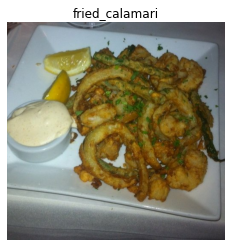

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

What we know about our data:
* In `unit8` datatype
* Comprised of all different size tensors.
* Not scaled (pixels between 0 and 255)

What we need for our data(what models like):
* Data in `float32` dtype (for mixed precision `float16` and `float32`)
* For batches tensorflow likes all of the tensors to be in a batch of same size eg. (224, 224, 3).
* Scaled (values between 0 & 1 ) also called normalized tensors generally perfrom better.

With these points in mind, we've got a few things, we can tackle within a preprocessing function.

Since we're going to use EfficientNetBX pretrained model we don't need to rescale our data.

In [ ]:
def preprocess_img(img, label, img_shape=224, rescale=False):
  """
  Convert image datatype from 'uint8' -> float32 and reshapes image to (img_shape, img_shape, colorchannel)
  and also normalize/scale it
  Args:
    img: image
    label: label from tupple (image, label)
    img_shape: image shape in which you wanted to resize it (default 224).
    rescale(bool): Rescales/normalize the image if needed
  Returns:
    Resized and dtype converted to float32 image more specifically.
    A tupple (float32_scaled_image, label).
  """
  image = tf.image.resize(img, [img_shape, img_shape])
  if rescale: 
    image = image/255. # not required for models like efficientnet
  return tf.cast(image, tf.float32), label

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape:{image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape:{preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n")

Image before preprocessing:
 [[[71 60 56]
  [70 59 55]
  [70 59 55]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]

 [[62 51 47]
  [64 53 49]
  [66 55 51]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]]...,
Shape:(512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 65.811226  54.811222  50.811222]
  [ 73.331635  62.331635  58.331635]
  [104.015305  89.80102   86.80102 ]
  ...
  [ 61.85712   59.071384  65.64286 ]
  [ 65.        60.        67.      ]
  [ 64.64282   59.642822  66.64282 ]]

 [[ 67.28571   56.285717  52.285717]
  [ 66.47449   55.47449   51.47449 ]
  [ 67.73979   53.525505  50.525505]
  ...
  [ 64.14284   61.3571    67.92857 ]
  [ 65.93368   60.933674  67.93368 ]
  [ 64.285645  59.285645  66.285645]]]...,
Shape:(224, 224, 3),
Datatype: <dtype: 'float32'>



## Batch and prepare dataset

We're now going to make our data input pipeline run really fast.
Went through https://www.tensorflow.org/guide/data_performance

In [ ]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle data, turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

Callbacks we think could be helpful:
* Tensorboard Callback
* ModelCheckpoint callback to save our model's progress after feature extraction

In [ ]:
# Creating checkpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

In [ ]:
# Turn on mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
!nvidia-smi

Sun Sep 11 01:48:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W /  70W |    286MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Build Feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model =   tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
for layer in model.layers:
  print(f"Datatype of {layer.name} is {layer.dtype} and its trainable attribute is {layer.trainable} whereas policy is {layer.dtype_policy}")

Datatype of input_layer is float32 and its trainable attribute is True whereas policy is <Policy "float32">
Datatype of efficientnetb0 is float32 and its trainable attribute is False whereas policy is <Policy "mixed_float16">
Datatype of global_average_pooling2d is float32 and its trainable attribute is True whereas policy is <Policy "mixed_float16">
Datatype of dense is float32 and its trainable attribute is True whereas policy is <Policy "mixed_float16">
Datatype of softmax_float32 is float32 and its trainable attribute is True whereas policy is <Policy "float32">


In [ ]:
# For efficient net
for i, layer in enumerate(model.layers[1].layers[:20]):
  print(i, layer.name, layer.dtype, layer.trainable, layer.dtype_policy)

0 input_1 float32 False <Policy "float32">
1 rescaling float32 False <Policy "mixed_float16">
2 normalization float32 False <Policy "mixed_float16">
3 stem_conv_pad float32 False <Policy "mixed_float16">
4 stem_conv float32 False <Policy "mixed_float16">
5 stem_bn float32 False <Policy "mixed_float16">
6 stem_activation float32 False <Policy "mixed_float16">
7 block1a_dwconv float32 False <Policy "mixed_float16">
8 block1a_bn float32 False <Policy "mixed_float16">
9 block1a_activation float32 False <Policy "mixed_float16">
10 block1a_se_squeeze float32 False <Policy "mixed_float16">
11 block1a_se_reshape float32 False <Policy "mixed_float16">
12 block1a_se_reduce float32 False <Policy "mixed_float16">
13 block1a_se_expand float32 False <Policy "mixed_float16">
14 block1a_se_excite float32 False <Policy "mixed_float16">
15 block1a_project_conv float32 False <Policy "mixed_float16">
16 block1a_project_bn float32 False <Policy "mixed_float16">
17 block2a_expand_conv float32 False <Policy 

In [ ]:
# Fitting
history_food_101_feature_extraction = model.fit(train_data,
                                                epochs=3,
                                                steps_per_epoch=(len(train_data)),
                                                validation_data=test_data,
                                                validation_steps=(0.15 * len(test_data)),
                                                callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                           experiment_name="efficientnetb0_101_classes_feature_extractor"),
                                                           model_checkpoint
                                                          ])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_feature_extractor/20220911-014955
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.6055 - accuracy: 0.5926

2368/2368 [==============================] - 187s 78ms/step - loss: 1.6055 - accuracy: 0.5926 - val_loss: 1.2547 - val_accuracy: 0.6623
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.3304 - accuracy: 0.6563

2368/2368 [==============================] - 179s 75ms/step - loss: 1.3304 - accuracy: 0.6563 - val_loss: 1.1905 - val_accuracy: 0.6849
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2062 - accuracy: 0.6861

2368/2368 [==============================] - 171s 72ms/step - loss: 1.2061 - accuracy: 0.6861 - val_loss: 1.1407 - val_accuracy: 0.6917


In [ ]:
results_feature_extractor = model.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 1.1546 - accuracy: 0.6894


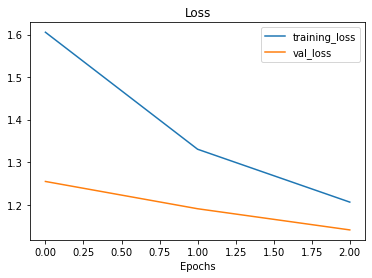

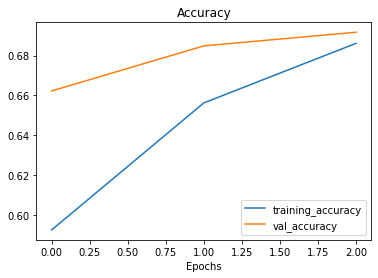

In [ ]:
plot_loss_curves(history_food_101_feature_extraction)

## Saving the model

We'll be saving the model and than loading it again and evaluate and compare the results to model we just built to make sure that it's loading and working properly.

In [ ]:
model.save("food_101_feature_extractor")

In [ ]:
loaded_model = tf.keras.models.load_model("food_101_feature_extractor")

In [ ]:
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 53s 64ms/step - loss: 1.1500 - accuracy: 0.6916


In [ ]:
loaded_model_results, results_feature_extractor

([1.1500461101531982, 0.6915643811225891],
 [1.1546133756637573, 0.6893861293792725])

From results above we can consider that our saved model is perfectly fine as per the results are nearly the same.

## Create Early Stopping callback and reduce learning rate callback


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3,
                                                  verbose=0)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

## Fine Tuning

In [ ]:
# Unfreezing all the layers
base_model.trainable = True

In [ ]:
# Recompiling
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"],
             )

In [ ]:
# Fitting fine tuned model
history_food_101_fine_tuned = model.fit(train_data,
                                        epochs=100,
                                        steps_per_epoch=(len(train_data)),
                                        validation_data=test_data,
                                        validation_steps=(0.15*len(test_data)),
                                         callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                     experiment_name="efficientnetb0_all_layers_unfrozen_food101"),
                                                    early_stopping,
                                                    model_checkpoint,
                                                    reduce_lr])

Saving TensorBoard log files to: training_logs/efficientnetb0_all_layers_unfrozen_food101/20220911-020230
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.1780 - accuracy: 0.6923

2368/2368 [==============================] - 403s 163ms/step - loss: 1.1780 - accuracy: 0.6923 - val_loss: 0.8557 - val_accuracy: 0.7597 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7377 - accuracy: 0.8012

2368/2368 [==============================] - 377s 159ms/step - loss: 0.7377 - accuracy: 0.8012 - val_loss: 0.7787 - val_accuracy: 0.7818 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.8543

2368/2368 [==============================] - 379s 159ms/step - loss: 0.5332 - accuracy: 0.8543 - val_loss: 0.7451 - val_accuracy: 0.7876 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.8974

2368/2368 [==============================] - 381s 160ms/step - loss: 0.3822 - accuracy: 0.8974 - val_loss: 0.7542 - val_accuracy: 0.7902 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.9269


Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 379s 159ms/step - loss: 0.2750 - accuracy: 0.9269 - val_loss: 0.7724 - val_accuracy: 0.7894 - lr: 1.0000e-04
Epoch 6/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.9620

2368/2368 [==============================] - 381s 160ms/step - loss: 0.1638 - accuracy: 0.9620 - val_loss: 0.7450 - val_accuracy: 0.7986 - lr: 2.0000e-05
Epoch 7/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9690

2368/2368 [==============================] - 382s 161ms/step - loss: 0.1380 - accuracy: 0.9690 - val_loss: 0.7347 - val_accuracy: 0.8041 - lr: 2.0000e-05
Epoch 8/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9737

2368/2368 [==============================] - 384s 161ms/step - loss: 0.1212 - accuracy: 0.9737 - val_loss: 0.7203 - val_accuracy: 0.8078 - lr: 2.0000e-05
Epoch 9/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9778

2368/2368 [==============================] - 382s 160ms/step - loss: 0.1079 - accuracy: 0.9778 - val_loss: 0.7261 - val_accuracy: 0.8101 - lr: 2.0000e-05
Epoch 10/100
2368/2368 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9798


Epoch 10: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==============================] - 377s 159ms/step - loss: 0.0973 - accuracy: 0.9798 - val_loss: 0.7383 - val_accuracy: 0.8075 - lr: 2.0000e-05
Epoch 11/100
2368/2368 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9837

2368/2368 [==============================] - 377s 159ms/step - loss: 0.0834 - accuracy: 0.9837 - val_loss: 0.7324 - val_accuracy: 0.8072 - lr: 4.0000e-06


## Evaluating mixed precision fine tuned model

In [ ]:
results_fine_tuned_mixed_precision = model.evaluate(test_data)

790/790 [==============================] - 52s 65ms/step - loss: 0.7465 - accuracy: 0.8034


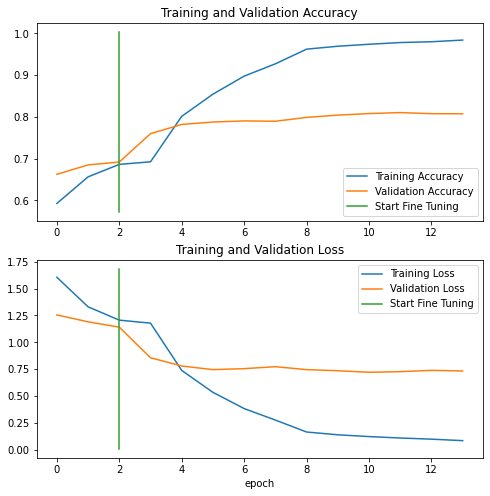

In [58]:
compare_historys(history_food_101_feature_extraction,history_food_101_fine_tuned, initial_epochs=3)

## Uploading to tensorboard

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuned model EfficientNetB0 on all Food101 Dataset" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Dataset" \
  --one_shot

https://tensorboard.dev/experiment/IRMJkcr7Qv29jubHbumZjQ/